<a href="https://colab.research.google.com/github/phantom-balance/TEP/blob/master/weekly_task_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM classification

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [2]:
# Setting up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size=12

In [ ]:
train_dataset=datasets.MNIST(root='dataset/',train=True,transform=transforms.ToTensor(),download=True)

In [5]:
print("training_data's_shape:",train_dataset[1][0][0].shape) # Each data to be classified has 28 rows and 28 columns

training_data's_shape: torch.Size([28, 28])


In [6]:
test_dataset=datasets.MNIST(root='dataset/',train=False,transform=transforms.ToTensor(),download=True)
batch_size=10
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [7]:
print("testing_data's_shape:",test_dataset[1][0][0].shape) # Each data to be classified has 28 rows and 28 columns

testing_data's_shape: torch.Size([28, 28])


labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


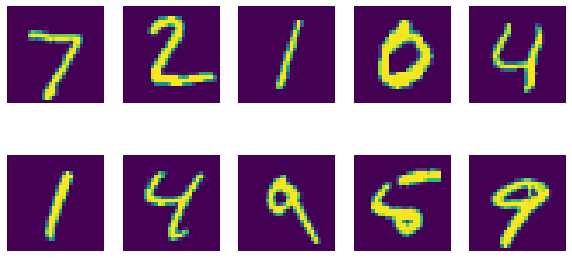

In [9]:
plt.figure(figsize=(10,5))
label = []
for i in range(10):
  plt.subplot(2, 5, i+1)
  image, target = test_loader.dataset.__getitem__(i)
  label.append(target)
  plt.imshow(image.squeeze().numpy())
  plt.axis('off')
print("labels:",label)

# We will be assuming that each row from the 28 rows represents a unique time stamp. And each column of the 28 columns represents a unique feature. {FOR OUR LSTM MODEL}

In [10]:
# Parameters
feature_size = 28
num_classes = 10
sequence_length = 28
num_hidden_layers = 2
hidden_units = 200
num_epochs = 2
learning_rate = 0.001

In [11]:
# Model
class LSTM(nn.Module):
  def __init__(self, feature_size, sequence_length, hidden_units, num_hidden_layers, num_classes):
    super().__init__()
    self.sequence_length = sequence_length
    self.hidden_units = hidden_units
    self.num_hidden_layers = num_hidden_layers
    self.lstm = nn.LSTM(feature_size, hidden_units, num_hidden_layers, batch_first=True)
    self.fc = nn.Linear(hidden_units*sequence_length, num_classes)
#    self.fc = nn.Linear(hidden_units, num_classes) # only training on the step -1 state

  def forward(self, x):
    h0 = torch.zeros(self.num_hidden_layers,x.size(0),self.hidden_units).to(device=device)
    c0=torch.zeros(self.num_hidden_layers,x.size(0),self.hidden_units).to(device=device)

    out, _ = self.lstm(x,(h0, c0))
    out = out.reshape(out.shape[0],-1)
    out= self.fc(out)
    return out

In [12]:
# Initializing model
model = LSTM(feature_size=feature_size,
             sequence_length=sequence_length,
             hidden_units=hidden_units,
             num_hidden_layers=num_hidden_layers,
             num_classes=num_classes).to(device)

In [13]:
# Loss and Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

#Performance metrics

#1.1 PERFORMANCE WITHOUT TRANING

In [14]:
test_loader=DataLoader(dataset=test_dataset,batch_size=10000,shuffle=False)

y_pred = []
y_true = []
y_prob = torch.double


with torch.no_grad():
  for data, labels in test_loader:
    scores = model(data.squeeze(1))
    prob = nn.Softmax(dim=1)
    y_prob = prob(scores)
    _, prediction = scores.max(1)
    y_pred.extend(prediction)
    y_true.extend(labels)


1.1.1 confusion matrix

In [15]:
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[   0    1    0    0    0    0    0  979    0    0]
 [   0  240    0    0    0    0    0  895    0    0]
 [   0   25    0    0    0    0    0 1007    0    0]
 [   0   42    0    0    0    0    0  968    0    0]
 [   0  204    0    0    0    0    0  778    0    0]
 [   0   14    0    0    0    0    0  878    0    0]
 [   0   47    0    0    0    0    0  911    0    0]
 [   0  313    0    0    0    0    0  715    0    0]
 [   0   17    0    0    0    0    0  957    0    0]
 [   0   63    0    0    0    0    0  946    0    0]]


precision_score_for_number0:0.098
recall_score_for_number0:1.0
f1_score_for_number0:0.1785063752276867
###########################################################
precision_score_for_number1:0.09907017932255922
recall_score_for_number1:0.788546255506608
f1_score_for_number1:0.17602517455010325
###########################################################
precision_score_for_number2:0.1032
recall_score_for_number2:1.0
f1_score_for_number2:0.18709209572153734
###########################################################
precision_score_for_number3:0.101
recall_score_for_number3:1.0
f1_score_for_number3:0.1834695731153497
###########################################################
precision_score_for_number4:0.0982
recall_score_for_number4:1.0
f1_score_for_number4:0.17883809870697503
###########################################################
precision_score_for_number5:0.0892
recall_score_for_number5:1.0
f1_score_for_number5:0.1637899375688579
################################################

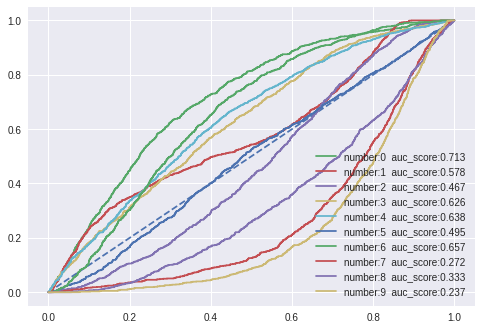

In [16]:
plt.style.use('seaborn')
plt.plot([0,1], [0,1], '--')

#Binary mode for each class
for i in range(10):
  y_true_temp=y_true.copy()
  y_pred_temp=y_pred.copy()
  for j in range(len(y_true)):
    if y_true_temp[j]==i:
      y_true_temp[j]= torch.tensor(1)
    else:
      y_true_temp[j]=torch.tensor(0)
    if y_pred_temp[j]==i:
      y_pred_temp[j] = torch.tensor(0)
    else:
      y_pred_temp[j]=torch.tensor(1)
    

  fpr, tpr, thresholds = roc_curve(y_true_temp, y_prob[:,i])
  roc_auc = roc_auc_score(y_true_temp, y_prob[:,i])
  plt.plot(fpr, tpr, label="number:"+str(i)+"  auc_score:"+str(f'{float(roc_auc):.3f}'))
  print("precision_score_for_number"+str(i)+":"+str(precision_score(y_true_temp, y_pred_temp)))
  print("recall_score_for_number"+str(i)+":"+str(recall_score(y_true_temp, y_pred_temp)))
  print("f1_score_for_number"+str(i)+":"+str(f1_score(y_true_temp, y_pred_temp)))
  print("###########################################################")
plt.legend(loc='lower right')

#1.2 PERFORMANCE AFTER TRAINING

In [17]:
# TRAINING IN SMALL CHUNKS(BATCH_SIZE)

batch_size = 10
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
for i in range(50):
  data, targets = next(iter(train_loader))
  #print('targets',targets)
  num_epochs = 3
  for epochs in range(num_epochs):
    data = data.to(device).squeeze(1) # changing the shape to 28x28
    targets = targets.to(device)
    scores = model(data)
    loss = criterion(scores, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# # TRAINING ENTIRE DATA IN EACH EPOCH
# num_epochs = 1
# for epochs in range(num_epochs):
#   for batch_idx, (data, targets) in enumerate(train_loader):
#     data = data.to(device).squeeze(1) # changing the shape to 28x28
#     targets = targets.to(device)
#     scores = model(data)
#     loss = criterion(scores, targets)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [ ]:
# # CHANGING THE SHAPE TO 28X28 IN ##TRAINING##

# for batch_idx, (data, targets) in enumerate(train_loader):
#   if batch_idx==0:
#     print(data[1].shape)
#     data = data.to(device).squeeze(1)
#     print(data[1].shape)

In [18]:
test_loader=DataLoader(dataset=test_dataset,batch_size=10000,shuffle=False)

y_pred = []
y_true = []
y_prob = torch.double


with torch.no_grad():
  for data, labels in test_loader:
    scores = model(data.squeeze(1))
    prob = nn.Softmax(dim=1)
    y_prob = prob(scores)
    _, prediction = scores.max(1)
    y_pred.extend(prediction)
    y_true.extend(labels)

1.2.1 confusion matrix

In [19]:
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[ 927    0   42    1    0    7    1    1    0    1]
 [   0 1028   92    2    1    6    3    0    0    3]
 [   9    0  934    7   29    2   13    3    3   32]
 [  17    3  200  631    0  126    7    3   15    8]
 [   1    3    3    1  491   10    6    3    4  460]
 [  30   10   53   47    7  614    6    7   60   58]
 [  65    3   33    0  139   50  599    1   10   58]
 [   6   24  185   64    1    2    0  625   14  107]
 [  13    2  242   36    2   79    0    2  562   36]
 [   9   12   29   14    4   15    0    5   17  904]]


precision_score_for_number0:0.8607242339832869
recall_score_for_number0:0.9459183673469388
f1_score_for_number0:0.9013125911521633
###########################################################
precision_score_for_number1:0.9474654377880184
recall_score_for_number1:0.905726872246696
f1_score_for_number1:0.9261261261261262
###########################################################
precision_score_for_number2:0.5151682294539437
recall_score_for_number2:0.9050387596899225
f1_score_for_number2:0.6565905096660808
###########################################################
precision_score_for_number3:0.7858032378580324
recall_score_for_number3:0.6247524752475248
f1_score_for_number3:0.6960838389409817
###########################################################
precision_score_for_number4:0.728486646884273
recall_score_for_number4:0.5
f1_score_for_number4:0.5929951690821256
###########################################################
precision_score_for_number5:0.6739846322722283
recall_score_fo

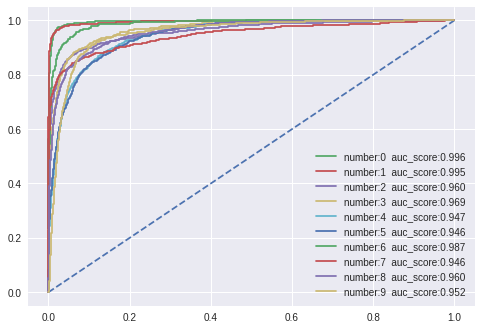

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score

plt.style.use('seaborn')
plt.plot([0,1], [0,1], '--')

#Binary mode for each class
for i in range(10):
  y_true_temp=y_true.copy()
  y_pred_temp=y_pred.copy()
  for j in range(len(y_true)):
    if y_true_temp[j]==i:
      y_true_temp[j]= torch.tensor(1)
    else:
      y_true_temp[j]=torch.tensor(0)
    if y_pred_temp[j]==i:
      y_pred_temp[j] = torch.tensor(1)
    else:
      y_pred_temp[j]=torch.tensor(0)
    

  fpr, tpr, thresholds = roc_curve(y_true_temp, y_prob[:,i])
  roc_auc = roc_auc_score(y_true_temp, y_prob[:,i])
  plt.plot(fpr, tpr, label="number:"+str(i)+"  auc_score:"+str(f'{float(roc_auc):.3f}'))
  print("precision_score_for_number"+str(i)+":"+str(precision_score(y_true_temp, y_pred_temp)))
  print("recall_score_for_number"+str(i)+":"+str(recall_score(y_true_temp, y_pred_temp)))
  print("f1_score_for_number"+str(i)+":"+str(f1_score(y_true_temp, y_pred_temp)))
  print("###########################################################")
plt.legend(loc='lower right')

In [21]:
from sklearn.metrics import multilabel_confusion_matrix


cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[[8870  150]
  [  53  927]]

 [[8808   57]
  [ 107 1028]]

 [[8089  879]
  [  98  934]]

 [[8818  172]
  [ 379  631]]

 [[8835  183]
  [ 491  491]]

 [[8811  297]
  [ 278  614]]

 [[9006   36]
  [ 359  599]]

 [[8947   25]
  [ 403  625]]

 [[8903  123]
  [ 412  562]]

 [[8228  763]
  [ 105  904]]]


#Simple accuracy test in testing_dataset

actual_labels tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
Got 7315/10000 correct, prediction rate=73.150
our_network's_prediction tensor([7, 2, 1, 0, 4, 1, 4, 9, 4, 9, 0, 4, 9, 0, 1, 5, 9, 7, 3, 4])


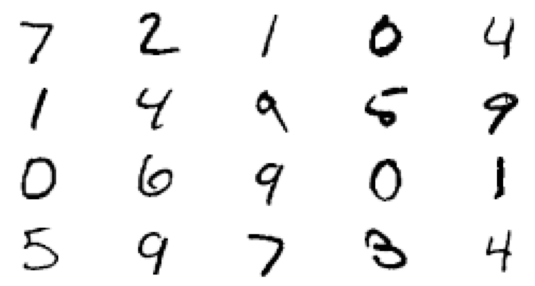

In [22]:
# Accuracy testing for TESTING data

data, labelss = next(iter(test_loader))
print("actual_labels",labelss[:20])
Predictions = []
def check_accuracy(data, targets, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
      x=data
      y=targets
      x=x.to(device=device).squeeze(1)
      y=y.to(device=device)
      scores=model(x)

      _, prediction= scores.max(1)
      Predictions.append(prediction)
      num_correct+=(prediction==y).sum()
      num_samples+=prediction.size(0)

    print(f'Got {num_correct}/{num_samples} correct, prediction rate={float(num_correct)/float(num_samples)*100:.3f}')
    model.train()

check_accuracy(data, labelss, model)
label = []
print("our_network's_prediction",Predictions[0][:20])


plt.figure(figsize=(10,5))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(data[i].squeeze().numpy())
  label.append(targets)
  plt.axis('off')

